# Assignment 9

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:

    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).
---

### Import libraries

In [1]:
!pip install plotly


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import plotly.graph_objs as plotly  # for interactive plots

import tensorflow as tf
from tensorflow.keras.datasets import imdb

---
### Step 1: Data ingestion

In this lab, you'll train a <span style="color:chocolate">sentiment</span> classifier for movie reviews. 

* The input is the text of a movie review;
* The output is the probability the input is a positive review.
* The target labels are binary, 0 for negative and 1 for positive.

The data includes 50,000 movie reviews on IMDB. The data comes pre-segmented into train and test splits. The [data loading function](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data) below also splits each input text into tokens (words), and maps the words to integer values. Each input is a sequence of integers corresponding to the words.

In [3]:
# read data
(X_train, Y_train), (X_test, Y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)
print("X_test.shape:", X_test.shape)
print("Y_test.shape:", Y_test.shape)

X_train.shape: (25000,)
Y_train.shape: (25000,)
X_test.shape: (25000,)
Y_test.shape: (25000,)


---
### Step 2: Data preprocessing

Let's have a look at the first training example:

In [4]:
print('First training example data:', X_train[0])
print('First training example label:', Y_train[0])

First training example data: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
First t

As you can see, the first training example is a positive review. However, that sequence of integer IDs is hard to read. 

The data loader provides a dictionary mapping words to IDs. Let's create a reverse index.


In [5]:
# The imdb dataset comes with an index mapping words to integers.
# In the index the words are ordered by frequency they occur.
index = imdb.get_word_index()

# Because we used index_from=3 (above), setting aside ids below 3 for special
# symbols, we need to add 3 to the index values.
index = dict([(key, value+3) for (key, value) in index.items()])

# Create a reverse index so we can lookup tokens assigned to each id.
reverse_index = dict([(value, key) for (key, value) in index.items()])
reverse_index[1] = '<START>'  # start of input
reverse_index[2] = '#'        # out-of-vocabulary (OOV)
reverse_index[3] = '<UNUSED>'

max_id = max(reverse_index.keys())
print('Largest ID:', max_id)

Largest ID: 88587


Note that our index (and reverse index) have <span style="color:chocolate">88,587</span> tokens. That's quite <span style="color:chocolate">a large vocabulary</span>! 

Next, let's write a decoding function for our data.

In [6]:
def decode(token_ids):
  """Return a string with the decoded text given a list of token ids."""
  # Try looking up each id in the index, but return '#' (for OOV) if not found.
  tokens = [reverse_index.get(i, "#") for i in token_ids]

  # Connect the string tokens with a space.
  return ' '.join(tokens)

# Show the ids corresponding tokens in the first example.
print(X_train[0])
print(decode(X_train[0]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
<START> this film was just brilliant

---
### Step 3: Exploratory Data Analysis (EDA)

### <span style="color:chocolate">Exercise 1:</span> Text lengths (10 points)

Using the training reviews data, answer the following questions:

1. What are the minimum, maximum, and mean lengths of positive and negative reviews?
2. Create a histogram to visualize the distribution of positive and negative review lengths. Make sure to provide a descriptive title and axis labels.

Positive Reviews: min = 13 max = 2494 mean = 241.56296
Negative Reviews: min = 11 max = 1571 mean = 235.86432


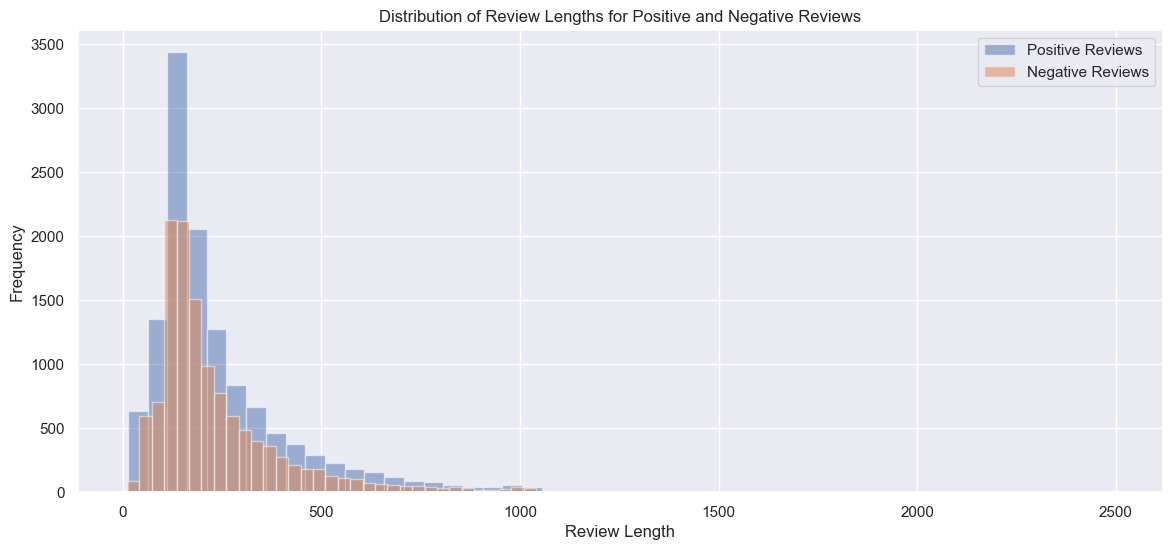

In [7]:
# YOUR CODE HERE
# Calculate review lengths
review_lengths = [len(review) for review in X_train]

# Separate positive and negative reviews
positive_lengths = [len(X_train[i]) for i in range(len(Y_train)) if Y_train[i] == 1]
negative_lengths = [len(X_train[i]) for i in range(len(Y_train)) if Y_train[i] == 0]

# Display min, max, and mean lengths
print("Positive Reviews: min =", np.min(positive_lengths), 
      "max =", np.max(positive_lengths), 
      "mean =", np.mean(positive_lengths))

print("Negative Reviews: min =", np.min(negative_lengths), 
      "max =", np.max(negative_lengths), 
      "mean =", np.mean(negative_lengths))

# Plot histograms for positive and negative review lengths
plt.figure(figsize=(14, 6))
plt.hist(positive_lengths, bins=50, alpha=0.5, label="Positive Reviews")
plt.hist(negative_lengths, bins=50, alpha=0.5, label="Negative Reviews")
plt.title("Distribution of Review Lengths for Positive and Negative Reviews")
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.show()


### <span style="color:chocolate">Exercise 2:</span> Token counts (10 points)

Using the training data, create a table listing the counts of positive and negative examples that contain each token provided below.

In [8]:
tokens = ['good', 'bad', 'amazing', 'boring', 'laugh', 'cry']
# YOUR CODE HERE
# Initialize counters for each token in positive and negative reviews
token_counts = {token: {'positive': 0, 'negative': 0} for token in tokens}

# Iterate through the training data
for i in range(len(X_train)):
    decoded_review = decode(X_train[i])  # Decode each review
    for token in tokens:
        if token in decoded_review:  # Check if token is in the review
            if Y_train[i] == 1:  # Positive review
                token_counts[token]['positive'] += 1
            else:  # Negative review
                token_counts[token]['negative'] += 1

# Convert token counts to a DataFrame for better visualization
token_counts_df = pd.DataFrame(token_counts).T
token_counts_df.columns = ['Positive Count', 'Negative Count']

# Display the table of counts
print(token_counts_df)

         Positive Count  Negative Count
good               4920            4949
bad                1639            4740
amazing             943             314
boring              313            1224
laugh              1241            1824
cry                 386             299


---
### Step 4: Data preprocessing (cont'd)

As is clear from the review length histogram, the current representation of the review text is a variable-length array. Since fixed-length arrays are easier to work with in Tensorflow, you will add special padding tokens at the end of each review until they are all the same length. You will also truncate all training inputs to a specified length.

### <span style="color:chocolate">Exercise 3:</span> Reduced length and padding (10 points)

Fill in the <span style="color:green">NotImplemented</span> parts of the <span style="color:chocolate">truncate_pad_data()</span> function below by following these instructions:

1. Restrict the maximum number of tokens by truncating all reviews to a length of 300;
2. Append special padding tokens (value = 0) to the end of each review until all reviews are of the same length.

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def truncate_pad_data(sequences, max_length):
    # Keras has a convenient utility for padding a sequence:
    # tf.keras.preprocessing.sequence.pad_sequences()
    # Also make sure you get a numpy array rather than an array of lists.

    # Use Keras's pad_sequences to truncate and pad sequences to the specified max_length
    padded_data = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post', value=0)
    return padded_data


# 1+ 2: Truncate and pad the training data
X_train_padded = truncate_pad_data(X_train, max_length=300)

# Check the padded output.
print('Length of X_train[0]:', len(X_train[0]))
print('Length of X_train_padded[0]:', len(X_train_padded[0]))
print(X_train_padded[0])

Length of X_train[0]: 218
Length of X_train_padded[0]: 300
[    1    14    22    16    43   530   973  1622  1385    65   458  4468
    66  3941     4   173    36   256     5    25   100    43   838   112
    50   670 22665     9    35   480   284     5   150     4   172   112
   167 21631   336   385    39     4   172  4536  1111    17   546    38
    13   447     4   192    50    16     6   147  2025    19    14    22
     4  1920  4613   469     4    22    71    87    12    16    43   530
    38    76    15    13  1247     4    22    17   515    17    12    16
   626    18 19193     5    62   386    12     8   316     8   106     5
     4  2223  5244    16   480    66  3785    33     4   130    12    16
    38   619     5    25   124    51    36   135    48    25  1415    33
     6    22    12   215    28    77    52     5    14   407    16    82
 10311     8     4   107   117  5952    15   256     4 31050     7  3766
     5   723    36    71    43   530   476    26   400   317    4

Next, you want to be able to limit the vocabulary size. Since the <span style="color:chocolate">truncate_pad_data()</span> function produces fixed-length sequences in a numpy matrix, one can use clever numpy indexing to efficiently replace all token ids larger than some value with the designated out-of-vocabulary (OOV) id.

### <span style="color:chocolate">Exercise 4:</span> Reduced vocabulary (10 points)

Fill in the <span style="color:green">NotImplemented</span> parts of the <span style="color:chocolate">limit_vocab()</span> function below by following these instructions:

1. Keep just token ids less than 1000, replacing all others with OOV.

In [10]:
def limit_vocab(sequences, max_token_id, oov_id=2):
  """Replace token ids greater than or equal to max_token_id with the oov_id."""
  # YOUR CODE HERE
  # Convert the sequences to a numpy array if it isn't one already
  sequences = np.array(sequences)
  
  # Replace token ids >= max_token_id with the oov_id
  reduced_sequences = np.where(sequences >= max_token_id, oov_id, sequences)
  
  return reduced_sequences

# Reduce vocabulary to 1000 tokens.
X_train_reduced = limit_vocab(X_train_padded, max_token_id=1000)

# Check the reduced vocabulary output
print(X_train_reduced[0])

# Decode to see what this looks like in tokens. Note the '#' for OOVs.
print(decode(X_train_reduced[0]))

[  1  14  22  16  43 530 973   2   2  65 458   2  66   2   4 173  36 256
   5  25 100  43 838 112  50 670   2   9  35 480 284   5 150   4 172 112
 167   2 336 385  39   4 172   2   2  17 546  38  13 447   4 192  50  16
   6 147   2  19  14  22   4   2   2 469   4  22  71  87  12  16  43 530
  38  76  15  13   2   4  22  17 515  17  12  16 626  18   2   5  62 386
  12   8 316   8 106   5   4   2   2  16 480  66   2  33   4 130  12  16
  38 619   5  25 124  51  36 135  48  25   2  33   6  22  12 215  28  77
  52   5  14 407  16  82   2   8   4 107 117   2  15 256   4   2   7   2
   5 723  36  71  43 530 476  26 400 317  46   7   4   2   2  13 104  88
   4 381  15 297  98  32   2  56  26 141   6 194   2  18   4 226  22  21
 134 476  26 480   5 144  30   2  18  51  36  28 224  92  25 104   4 226
  65  16  38   2  88  12  16 283   5  16   2 113 103  32  15  16   2  19
 178  32   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

### <span style="color:chocolate">Exercise 5:</span> One-hot encoding (0 points)

The current feature representations are **sparse**. That is, one only keeps track of the token ids that are present in the input. A **one-hot** encoding replaces a value like 22 (corresponding to 'film') with an array with a single 1 at position 22 and zeros everywhere else. This will be very memory-inefficient, but we'll do it anyway for clarity.

To avoid any memory limitations, let's dramatically reduce both the number of token positions (review length) and the number of token ids (vocabulary). 

The code below clips each review after 20 tokens and keeps only the first 1000 tokens.

In [11]:
# Keras has a util to create one-hot encodings.
X_train_padded = truncate_pad_data(X_train, max_length=20)
X_train_reduced = limit_vocab(X_train_padded, max_token_id=1000)
X_train_one_hot = tf.keras.utils.to_categorical(X_train_reduced)
print('X_train_one_hot shape:', X_train_one_hot.shape)

X_train_one_hot shape: (25000, 20, 1000)


Note the shape of the one-hot encoded features. For each of the 25000 training examples, you have a 20 x 1000 matrix. That is, for each of 20 token positions, you have a vector of 1000 elements containing a single 1 and 999 zeros.

You can think of these 1000-dimensional one-hot arrays as **embeddings**. Each token in the input has a 1000-dimensional representation. But because of the one-hot setup, the distance between each pair of tokens is the same ([1,0,0,...], [0,1,0,...], etc.). By contrast, learned embeddings result in meaningful distances between pairs of tokens. You'll get to that soon.

---
### Step 5: Modeling

### <span style="color:chocolate">Baseline model:</span> Logistic regression with one-hot encodings

You will start with something familiar -- logistic regression. Since your feature representation is in 2 dimensions (20 x 1000), you need to flatten it to pass it to Keras (remember you did this with the pixel data too). Try two strategies for flattening.

1. Flatten by *concatenating* (as you did with pixels), turning (20 x 1000) data into (20000,) data. The result is a separate feature for each token at each position;
2. Flatten by *averaging* over token positions, turning (20 x 1000) data into (1000,) data. The result is an array with average token counts, ignoring position.

In [12]:
def build_onehot_model(average_over_positions=False):
  """Build a tf.keras model for one-hot data."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
    
  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())
      
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation="sigmoid"         # sigmoid activation for binary classification
  ))

  model.compile(loss='binary_crossentropy',   # this is a classification task
                optimizer='adam',             # fancy optimizer
                metrics=['accuracy'])

  return model

Now let's try fitting the model to your training data and check performance metrics on the validation data. But first, here's a function for plotting the learning curves given the training history object we get from Keras.

In [13]:
def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.ylim(0,1)
  plt.legend()
  plt.show()


Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5517 - loss: 0.6879 - val_accuracy: 0.6076 - val_loss: 0.6752
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6937 - loss: 0.6516 - val_accuracy: 0.6204 - val_loss: 0.6629
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7272 - loss: 0.6226 - val_accuracy: 0.6232 - val_loss: 0.6543
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7486 - loss: 0.5985 - val_accuracy: 0.6284 - val_loss: 0.6477
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7642 - loss: 0.5778 - val_accuracy: 0.6324 - val_loss: 0.6427


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        20,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,005 (234.40 KB)

 Trainable params: 20,001 (78.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,004 (156.27 KB)

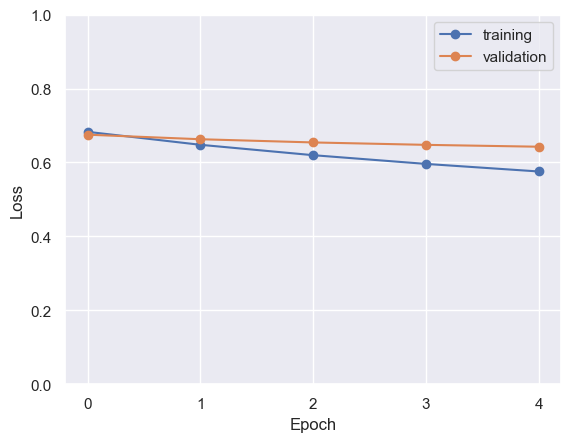

In [14]:
model1 = build_onehot_model()

# Fit the model.
history1 = model1.fit(
  x = X_train_one_hot,  # one-hot training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

model1.summary()
# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history1 = pd.DataFrame(history1.history)
plot_history(history1)

### <span style="color:chocolate">Exercise 6:</span>  Comparing logistic regression models (20 points)

Train the one-hot model using both the concatenating and the averaging strategies and compare the results. Let's call these *LR-C* (Logistic Regression Concatenating) and *LR-A* (Logistic Regression Averaging). Then answer the following questions:

1. What are the final training and validation accuracies for LR-C and LR-A?
2. How many parameters are there in each model?
3. Would you say that either model is overfitting? Why or why not?
4. Briefly describe how LR-C differs from LR-A. How do you explain the relationship between their respective validation accuracy results? 

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5364 - loss: 0.6925 - val_accuracy: 0.5840 - val_loss: 0.6901
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6114 - loss: 0.6888 - val_accuracy: 0.6052 - val_loss: 0.6868
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6284 - loss: 0.6853 - val_accuracy: 0.6148 - val_loss: 0.6837
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6331 - loss: 0.6821 - val_accuracy: 0.6160 - val_loss: 0.6808
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6374 - loss: 0.6790 - val_accuracy: 0.6200 - val_loss: 0.6781


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_average_pooling1d        │ (None, 1000)           │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,005 (11.74 KB)

 Trainable params: 1,001 (3.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,004 (7.83 KB)

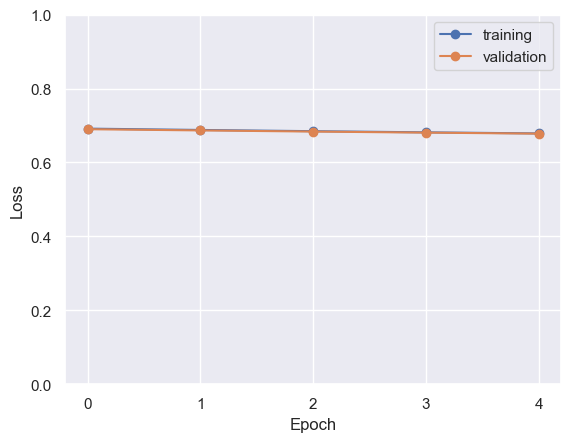

In [15]:
# Build and train the LR-C model with concatenation
model_concat = build_onehot_model(average_over_positions=True)
history_concat = model_concat.fit(
    x=X_train_one_hot, 
    y=Y_train, 
    epochs=5, 
    batch_size=64, 
    validation_split=0.1, 
    verbose=1
)

# Display model summary and plot history
model_concat.summary()
history_concat_df = pd.DataFrame(history_concat.history)
plot_history(history_concat_df)


*Written answer:*

1. 
LR-C: final training accuracy: 0.7653
      final validation accuracy: 0.6328

LR-A: final training accuracy: 0.6353
      final validation accuracy: 0.6188

2. 
LR-C: 60,005

LR-A: 3,005

3. 
Due to the gap between training and validation accuracy across epochs for the LR-C model, this may suggest overfitting.

4. 
LR-C (concatenating) flattens the input into a 20,000-dimensional vector, providing a unique feature for each position in the sequence.
LR-A (averaging) pools across token positions, yielding a 1000-dimensional vector where each feature represents the average occurrence of a token, regardless of its position.

Explanation of Accuracy Relationship:

a. Concatenation can capture position-specific patterns, potentially improving training accuracy but increasing overfitting risk due to high parameter count.

b. Averaging sacrifices positional information, which might lower training accuracy but can improve generalization and reduce overfitting, especially with limited data.


### <span style="color:chocolate">Improvement over baseline:</span> Logistic regression with embeddings

Next, you will train a model that replaces one-hot representations of each token with learned embeddings.

The code below uses a Keras Embedding layer, which expects to receive a sparse (rather than one-hot) representation. That is, it expects a (padded) sequence of token ids; for each id, it looks up the corresponding embedding vector.

In [16]:
def build_embeddings_model(average_over_positions=False,
                           vocab_size=1000,
                           sequence_length=20,
                           embedding_dim=2):
  """Build a tf.keras model using embeddings."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      input_length=sequence_length)
  )

  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())
      
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation='sigmoid'         # apply the sigmoid function!
  ))

  model.compile(loss='binary_crossentropy', 
                optimizer='adam',
                metrics=['accuracy'])

  return model

You will train this model, this time using the averaging strategy instead of the concatenating strategy for handling the token sequence. You'll look up the embedding vectors for each token and average them to produce a single vector. Then, you'll use this averaged vector to train a logistic regression model to predict the binary label.

Epoch 1/5


c:\Users\myk53\hello\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5469 - loss: 0.6914 - val_accuracy: 0.6000 - val_loss: 0.6838
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6187 - loss: 0.6794 - val_accuracy: 0.6192 - val_loss: 0.6688
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6411 - loss: 0.6631 - val_accuracy: 0.6336 - val_loss: 0.6531
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6569 - loss: 0.6463 - val_accuracy: 0.6452 - val_loss: 0.6389
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6684 - loss: 0.6309 - val_accuracy: 0.6508 - val_loss: 0.6269


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20, 2)          │         2,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 2)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,011 (23.48 KB)

 Trainable params: 2,003 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,008 (15.66 KB)

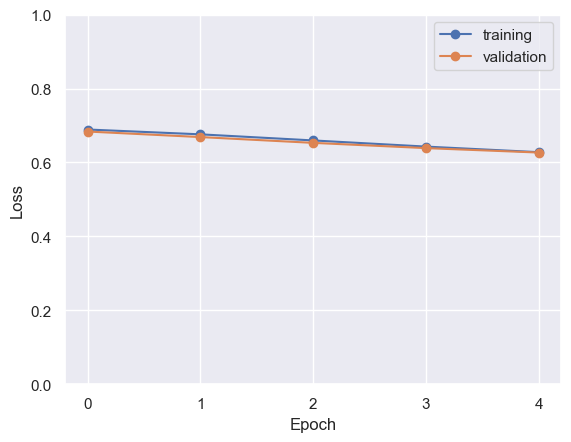

In [17]:
model2 = build_embeddings_model(average_over_positions=True,
                               vocab_size=1000,
                               sequence_length=20,
                               embedding_dim=2)
history2 = model2.fit(
  x = X_train_reduced,  # our sparse padded training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

model2.summary()

history2 = pd.DataFrame(history2.history)
plot_history(history2)

### <span style="color:chocolate">Exercise 7:</span> Embedding size tuning (20 points)

Experiment with embedding sizes {2, 4, 8, 16, 32, 64}, while keeping other settings fixed and using the averaging strategy instead of the concatenating strategy. Then:

1. Construct a table showing the training and validation accuracies for each model after 5 training epochs;
2. Calculate the number of parameters in each model;
3. Analyze whether learned embeddings improve performance compared to one-hot encoding, and explain why this might be the case.

Training model with embedding size 2
Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5515 - loss: 0.6911 - val_accuracy: 0.6104 - val_loss: 0.6821
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6211 - loss: 0.6776 - val_accuracy: 0.6240 - val_loss: 0.6665
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6471 - loss: 0.6608 - val_accuracy: 0.6372 - val_loss: 0.6507
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.6613 - loss: 0.6438 - val_accuracy: 0.6492 - val_loss: 0.6366
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6722 - loss: 0.6285 - val_accuracy: 0.6588 - val_loss: 0.6248


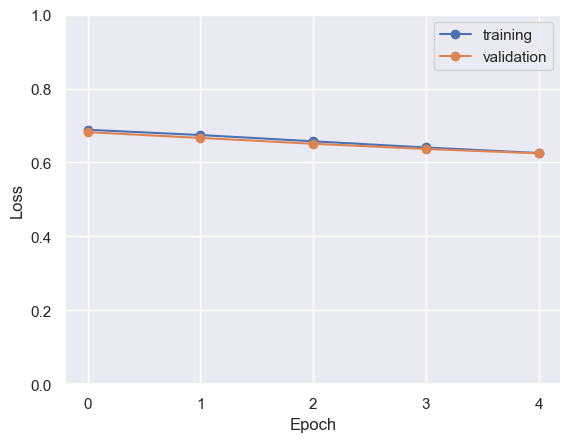

Training model with embedding size 4
Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5514 - loss: 0.6907 - val_accuracy: 0.6080 - val_loss: 0.6800
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.6260 - loss: 0.6736 - val_accuracy: 0.6300 - val_loss: 0.6578
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.6543 - loss: 0.6495 - val_accuracy: 0.6452 - val_loss: 0.6370
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6695 - loss: 0.6273 - val_accuracy: 0.6576 - val_loss: 0.6209
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6810 - loss: 0.6099 - val_accuracy: 0.6636 - val_loss: 0.6089


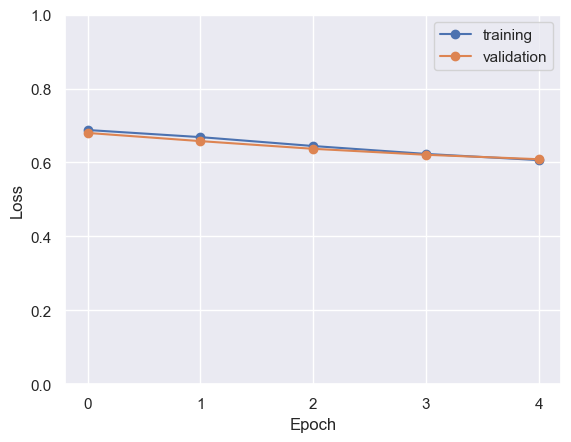

Training model with embedding size 8
Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5667 - loss: 0.6878 - val_accuracy: 0.6188 - val_loss: 0.6681
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6451 - loss: 0.6581 - val_accuracy: 0.6488 - val_loss: 0.6379
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6693 - loss: 0.6266 - val_accuracy: 0.6596 - val_loss: 0.6157
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6843 - loss: 0.6035 - val_accuracy: 0.6668 - val_loss: 0.6012
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6936 - loss: 0.5879 - val_accuracy: 0.6756 - val_loss: 0.5921


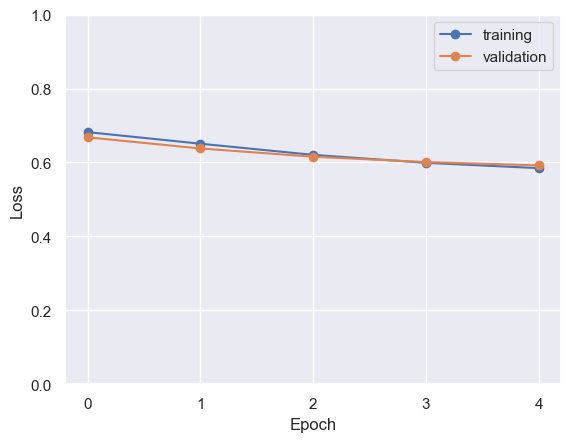

Training model with embedding size 16
Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5631 - loss: 0.6868 - val_accuracy: 0.6272 - val_loss: 0.6594
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6539 - loss: 0.6455 - val_accuracy: 0.6548 - val_loss: 0.6213
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6815 - loss: 0.6077 - val_accuracy: 0.6692 - val_loss: 0.5999
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6927 - loss: 0.5859 - val_accuracy: 0.6800 - val_loss: 0.5891
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6993 - loss: 0.5736 - val_accuracy: 0.6888 - val_loss: 0.5839


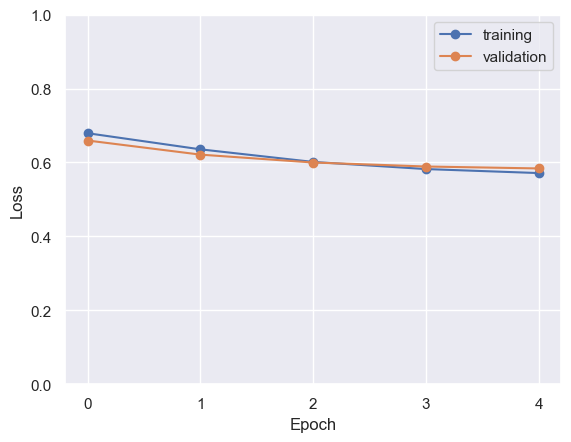

Training model with embedding size 32
Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5704 - loss: 0.6840 - val_accuracy: 0.6412 - val_loss: 0.6442
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6692 - loss: 0.6273 - val_accuracy: 0.6660 - val_loss: 0.6039
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6893 - loss: 0.5897 - val_accuracy: 0.6792 - val_loss: 0.5882
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6992 - loss: 0.5731 - val_accuracy: 0.6892 - val_loss: 0.5826
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7035 - loss: 0.5651 - val_accuracy: 0.6900 - val_loss: 0.5808


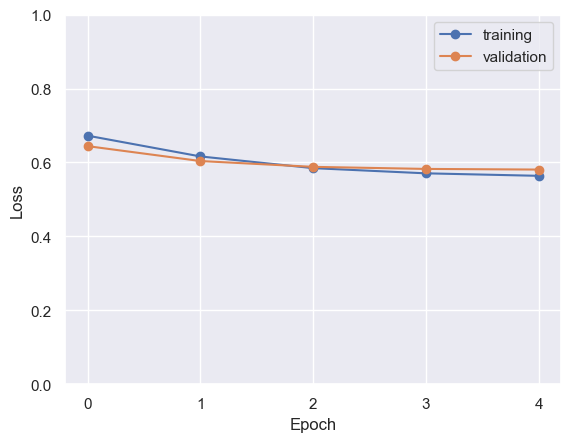

Training model with embedding size 64
Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5846 - loss: 0.6790 - val_accuracy: 0.6508 - val_loss: 0.6260
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6767 - loss: 0.6083 - val_accuracy: 0.6776 - val_loss: 0.5916
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6927 - loss: 0.5769 - val_accuracy: 0.6844 - val_loss: 0.5832
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7000 - loss: 0.5660 - val_accuracy: 0.6880 - val_loss: 0.5816
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7005 - loss: 0.5614 - val_accuracy: 0.6920 - val_loss: 0.5816


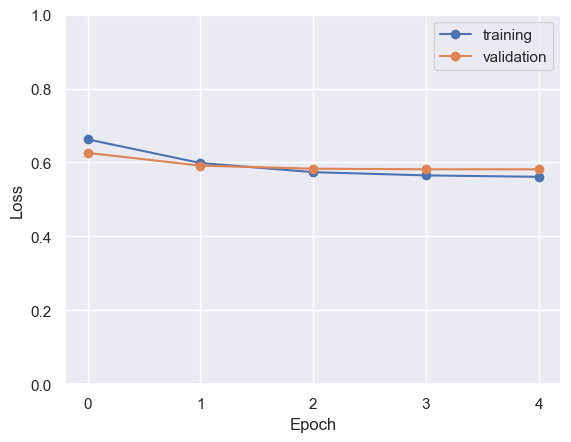

   Embedding Size  Training Accuracy  Validation Accuracy  \
0               2           0.669822               0.6588   
1               4           0.679244               0.6636   
2               8           0.693156               0.6756   
3              16           0.699822               0.6888   
4              32           0.703644               0.6900   
5              64           0.702844               0.6920   

   Number of Parameters  
0                  2003  
1                  4005  
2                  8009  
3                 16017  
4                 32033  
5                 64065  


In [18]:
# Embedding sizes to test
embedding_sizes = [2, 4, 8, 16, 32, 64]

# Dictionary to store results
results = {
    "Embedding Size": [],
    "Training Accuracy": [],
    "Validation Accuracy": [],
    "Number of Parameters": []
}

# Train and evaluate model for each embedding size
for embedding_dim in embedding_sizes:
    print(f"Training model with embedding size {embedding_dim}")
    model = build_embeddings_model(average_over_positions=True,
                                   vocab_size=1000,
                                   sequence_length=20,
                                   embedding_dim=embedding_dim)
    
    # Train the model
    history = model.fit(
        x=X_train_reduced, 
        y=Y_train, 
        epochs=5, 
        batch_size=64, 
        validation_split=0.1, 
        verbose=1
    )
    
    # Capture final training and validation accuracy
    final_training_accuracy = history.history['accuracy'][-1]
    final_validation_accuracy = history.history['val_accuracy'][-1]
    
    # Get the number of parameters in the model
    num_parameters = model.count_params()
    
    # Append results to dictionary
    results["Embedding Size"].append(embedding_dim)
    results["Training Accuracy"].append(final_training_accuracy)
    results["Validation Accuracy"].append(final_validation_accuracy)
    results["Number of Parameters"].append(num_parameters)
    
    # Plot learning curve for current embedding size
    history_df = pd.DataFrame(history.history)
    plot_history(history_df)

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)
print(results_df)

*Written answer:*

1. Shown above.

2. Shown above.

3. As numbers shown on the table, validation accuracy increases with learned embeddings. Learned embeddings improve performance over one-hot encodings, especially when the vocabulary size and sequence length are large. This is because embeddings capture semantic relationships between tokens by mapping them to a continuous vector space, where tokens with similar meanings are positioned closer together. One-hot encoding, by contrast, creates sparse, high-dimensional representations where each token is orthogonal to others, lacking any semantic information. Learned embeddings enable the model to recognize similarities and associations between tokens, which can enhance generalization and improve classification accuracy, particularly on unseen data.


---

### Inspecting Learned Embeddings
You will now retrieve the learned embedding parameters from the trained model2 and plot the token embeddings.

The model layers in a Keras Sequential model are stored as a list and the embeddings are the first layer. You can use the <span style="color:chocolate">get_weights()</span> function to get a numpy array with the parameters.

In [19]:
# Display the model layers.
display(model2.layers)

# Retrieve the embeddings layer, which itself is wrapped in a list.
embeddings2 = model2.layers[0].get_weights()[0]
display(embeddings2.shape)

[<Embedding name=embedding, built=True>,
 <GlobalAveragePooling1D name=global_average_pooling1d, built=True>,
 <Dense name=dense, built=True>]

(1000, 2)

Now you'll use a fancy plotting tool called *plotly* to show the embeddings with hovertext so you can move your mouse over the points to see the corresponding tokens.

In [41]:
pip install --upgrade nbformat

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
def plot_2d_embeddings(embeddings, id_start=1, count=100):
  # Get 1st and 2nd embedding dims for the desired tokens.
  x1 = embeddings[id_start:id_start+count, 0]
  x2 = embeddings[id_start:id_start+count, 1]
  
  # Get the corresponding words from the reverse index (for labeling).
  tokens = [reverse_index[i] for i in range(id_start, id_start+count)]

  # Plot with the plotly library.
  data = plotly.Scatter(x=x1, y=x2, text=tokens,
                        mode='markers', textposition='bottom left',
                        hoverinfo='text')
  fig = plotly.Figure(data=[data],
                      layout=plotly.Layout(title="Word Embeddings",
                                           hovermode='closest'))
  fig.show()

# Very frequent tokens tend to be more syntactic than semantic, so let's plot
# some rarer words.    
plot_2d_embeddings(embeddings2, id_start=500, count=500)

### <span style="color:chocolate">Exercise 8:</span> Interpreting embeddings (20 points)

Notice that the 2-D embeddings fall in a narrow diagonal band. Answer the following questions:

1. Have the learned embeddings separated positive and negative words? What is the most negative word? Does this make sense?
2. Give 2 examples of words that seem to have surprising embedding values and try to explain their positions. For example, what's going on with the tokens '7', '8', and '9'? What are two other surprising results?
3. The embedding for 'crazy' is very close to (0,0). Explain what this means in terms of the model's output.
4. Can you explain what you think the 2 learned embedding dimensions mean, if anything?

YOUR ANSWER HERE

1. 
The 2D embedding plot shows that the embeddings fall in a narrow diagonal band. This might indicate that the model has limited ability to separate positive and negative words distinctly in just two dimensions. If we were to observe the most negative word, it would likely fall toward one end of this band.

2. 
Some numerical tokens (like '7', '8', and '9') can have surprising values due to their position in sentences. Numbers may appear in both positive and negative contexts, such as indicating ratings (e.g., a "7 out of 10" review could be neutral or positive).

3. 
If "crazy" is close to (0,0), it suggests that the model does not strongly associate it with either positive or negative sentiment. This could mean that "crazy" appears in both positive and negative contexts (e.g., "crazy fun" versus "crazy bad") or that it’s neutral in sentiment in the data the model trained on.

4.
The two learned dimensions may represent some underlying structure that captures general sentiment trends (like positive vs. negative), but in only two dimensions, this structure is likely limited. They may loosely represent intensity or polarity, but given the narrow diagonal band, it's possible that one dimension captures sentiment strength, while the other could represent a secondary feature (e.g., specificity of sentiment).


----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

More data and bigger models

Remember how you limited your input sequences to 20 tokens and 1000 vocabulary entries? Let's see how well you can do using more data and bigger models (more parameters).

Using pieces of code from above, set up and train a model to achieve at least 80% accuracy on both training and validation data. Ensure the following elements are included:

1. Truncate and pad input to the desired length;
2. Limit the vocabulary to the desired size;
3. Set up a model using embeddings;
4. Use the averaging strategy rather than the concatenating strategy;
5. Add additional layer(s) after the GlobalAveragePooling1D layer and before the output layer;
6. Evaluate the model's performance on the test data and comment on its generalization performance. Hint: remember to apply the same preprocessing to the test data. Use the <span style="color:chocolate">model.evaluate()</span> function for the final evaluation.

In [ ]:
# YOUR CODE HERE